## BAYESIAN REGRESSION


### test vs train auc issue

15:40:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:40:27 - cmdstanpy - INFO - CmdStan done processing.


15:40:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:40:37 - cmdstanpy - INFO - CmdStan done processing.


15:40:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:40:50 - cmdstanpy - INFO - CmdStan done processing.


15:40:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:41:02 - cmdstanpy - INFO - CmdStan done processing.


15:41:03 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:41:14 - cmdstanpy - INFO - CmdStan done processing.


15:41:15 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:41:27 - cmdstanpy - INFO - CmdStan done processing.


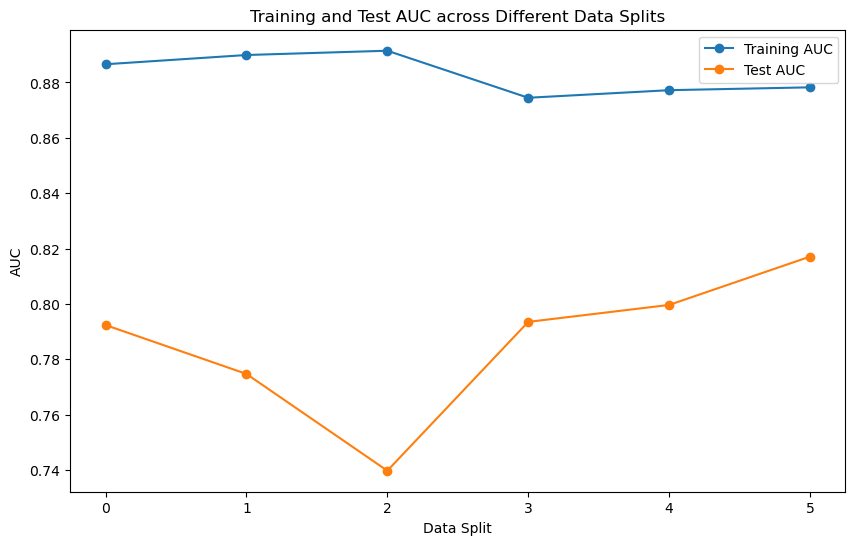

Mean Training AUC: 0.8830
Mean Test AUC: 0.7862
Training AUCs: [0.8865556169574484, 0.8898954077043661, 0.891444600280505, 0.8744587137802192, 0.8771950271950272, 0.8782251377847143]
Test AUCs: [0.7923901460540339, 0.7747368421052632, 0.7397791903646705, 0.7935275080906149, 0.7996505532906232, 0.8170941449188663]


In [17]:
import pandas as pd
import numpy as np
import arviz as az
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)

# Ensure the 'outcome' column is present
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")

# Convert the 'outcome' column to integer type
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Function to train the model and calculate AUC
def train_and_evaluate(data, predictor_names, stan_file, seed):
    # Split the data into training and validation sets
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=seed)

    # Prepare data for Stan model
    stan_data = {
        'N': train_data.shape[0],
        'K': len(predictor_names),
        'X': train_data[predictor_names].values,
        'y': train_data['outcome'].values
    }

    # Compile and sample from Stan model
    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(data=stan_data, seed=seed, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

    # Convert the CmdStanPy output to ArviZ's InferenceData object
    idata = az.from_cmdstanpy(fit)

    # Extract the samples
    beta_samples = idata.posterior['beta'].mean(dim=['chain', 'draw']).values

    # Predict on the training data
    train_preds_prob = 1 / (1 + np.exp(-(np.dot(train_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    train_auc = roc_auc_score(train_data['outcome'], train_preds_prob)

    # Predict on the test data
    test_preds_prob = 1 / (1 + np.exp(-(np.dot(valid_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    test_auc = roc_auc_score(valid_data['outcome'], test_preds_prob)

    return train_auc, test_auc

# Perform multiple data splits and calculate AUCs
num_splits = 6
train_aucs = []
test_aucs = []

for seed in range(num_splits):
    train_auc, test_auc = train_and_evaluate(data, predictor_names, 'logistic_regression_cauchy.stan', seed)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(range(num_splits), train_aucs, label='Training AUC', marker='o')
plt.plot(range(num_splits), test_aucs, label='Test AUC', marker='o')
plt.xlabel('Data Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC across Different Data Splits')
plt.legend()
plt.show()

# Print the results
print(f"Mean Training AUC: {np.mean(train_aucs):.4f}")
print(f"Mean Test AUC: {np.mean(test_aucs):.4f}")
print(f"Training AUCs: {train_aucs}")
print(f"Test AUCs: {test_aucs}")


### normal tests

In [1]:
import pandas as pd
import numpy as np
import arviz as az
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("RF_imputation_NEW.csv")

# Drop unnecessary columns
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)

# Ensure the 'outcome' column is present
if 'outcome' not in data.columns:
    raise ValueError("The 'outcome' column does not exist in the dataframe.")

# Convert the 'outcome' column to integer type
data['outcome'] = data['outcome'].astype(int)

# Normalize the predictors
predictor_names = data.columns.difference(['outcome'])
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Function to train the model and calculate AUC
def train_and_evaluate(data, predictor_names, stan_file, seed):
    # Split the data into training and validation sets
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=seed)

    # Prepare data for Stan model
    stan_data = {
        'N': train_data.shape[0],
        'K': len(predictor_names),
        'X': train_data[predictor_names].values,
        'y': train_data['outcome'].values
    }

    # Compile and sample from Stan model
    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(data=stan_data, seed=seed, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

    # Convert the CmdStanPy output to ArviZ's InferenceData object
    idata = az.from_cmdstanpy(fit)

    # Extract the samples
    beta_samples = idata.posterior['beta'].mean(dim=['chain', 'draw']).values

    # Predict on the training data
    train_preds_prob = 1 / (1 + np.exp(-(np.dot(train_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    train_auc = roc_auc_score(train_data['outcome'], train_preds_prob)

    # Predict on the test data
    test_preds_prob = 1 / (1 + np.exp(-(np.dot(valid_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    test_auc = roc_auc_score(valid_data['outcome'], test_preds_prob)

    return train_auc, test_auc

# Perform multiple data splits and calculate AUCs
num_splits = 10
train_aucs = []
test_aucs = []

for seed in range(num_splits):
    train_auc, test_auc = train_and_evaluate(data, predictor_names, 'logistic_regression.stan', seed)
    train_aucs.append(train_auc)
    test_aucs.append(test_auc)

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.plot(range(num_splits), train_aucs, label='Training AUC', marker='o')
plt.plot(range(num_splits), test_aucs, label='Test AUC', marker='o')
plt.xlabel('Data Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC across Different Data Splits')
plt.legend()
plt.show()

# Print the results
print(f"Mean Training AUC: {np.mean(train_aucs):.4f}")
print(f"Mean Test AUC: {np.mean(test_aucs):.4f}")
print(f"Training AUCs: {train_aucs}")
print(f"Test AUCs: {test_aucs}")


14:11:04 - cmdstanpy - INFO - No CmdStan installation found.
14:11:04 - cmdstanpy - INFO - Cannot determine whether version is before 2.27.
14:11:04 - cmdstanpy - INFO - No CmdStan installation found.
14:11:04 - cmdstanpy - INFO - Cannot determine whether version is before 2.27.


ValueError: No CmdStan installation found, run command "install_cmdstan"or (re)activate your conda environment!

### test new

In [25]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Function to prepare Stan data
def prepare_stan_data(train_data, predictor_names):
    return {
        'N': train_data.shape[0],
        'K': len(predictor_names),
        'X': train_data[predictor_names].values,
        'y': train_data['outcome'].values
    }

# Function to train and evaluate the model
def train_and_evaluate(train_data, valid_data, predictor_names, stan_file, random_seed):
    stan_data = prepare_stan_data(train_data, predictor_names)
    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(data=stan_data, seed=random_seed, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)
    idata = az.from_cmdstanpy(fit)
    beta_samples = idata.posterior['beta'].mean(dim=['chain', 'draw']).values

    # Predict on the training data
    train_preds_prob = 1 / (1 + np.exp(-(np.dot(train_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    train_auc = roc_auc_score(train_data['outcome'], train_preds_prob)

    # Predict on the test data
    test_preds_prob = 1 / (1 + np.exp(-(np.dot(valid_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    test_auc = roc_auc_score(valid_data['outcome'], test_preds_prob)

    return train_auc, test_auc

# Set a fixed random seed for reproducibility
random_seed = 213

# Preprocess data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed)

# Train and evaluate the model
train_auc, test_auc = train_and_evaluate(train_data, valid_data, predictor_names, 'logistic_regression_cauchy.stan', random_seed)

# Print results
print("Train AUC:", train_auc)
print("Test AUC:", test_auc)


15:59:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:59:48 - cmdstanpy - INFO - CmdStan done processing.



Train AUC: 0.8742190488333546
Test AUC: 0.7973235195717631


## Normal

In [28]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Function to prepare Stan data
def prepare_stan_data(train_data, predictor_names):
    return {
        'N': train_data.shape[0],
        'K': len(predictor_names),
        'X': train_data[predictor_names].values,
        'y': train_data['outcome'].values
    }

# Function to train and evaluate the model
def train_and_evaluate(train_data, valid_data, predictor_names, stan_file, random_seed):
    stan_data = prepare_stan_data(train_data, predictor_names)
    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(data=stan_data, seed=random_seed, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)
    idata = az.from_cmdstanpy(fit)
    beta_samples = idata.posterior['beta'].mean(dim=['chain', 'draw']).values

    # Predict on the training data
    train_preds_prob = 1 / (1 + np.exp(-(np.dot(train_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    train_auc = roc_auc_score(train_data['outcome'], train_preds_prob)

    # Predict on the test data
    test_preds_prob = 1 / (1 + np.exp(-(np.dot(valid_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    test_auc = roc_auc_score(valid_data['outcome'], test_preds_prob)

    return train_auc, test_auc

# Set a fixed random seed for reproducibility
random_seed = 213

# Preprocess data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed)

# Train and evaluate the model
train_auc, test_auc = train_and_evaluate(train_data, valid_data, predictor_names, 'logistic_regression.stan', random_seed)

# Print results
print("Train AUC:", train_auc)
print("Test AUC:", test_auc)


16:07:50 - cmdstanpy - INFO - compiling stan file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression.stan to exe file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression
16:07:56 - cmdstanpy - INFO - compiled model executable: /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression
16:07:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:08:01 - cmdstanpy - INFO - CmdStan done processing.



Train AUC: 0.8736452887925539
Test AUC: 0.7967213114754099


### horseshoe

In [30]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Function to preprocess data
def preprocess_data(data, predictor_names, random_seed):
    scaler = StandardScaler()
    data[predictor_names] = scaler.fit_transform(data[predictor_names])
    train_data, valid_data = train_test_split(data, test_size=0.3, random_state=random_seed)
    return train_data, valid_data

# Function to prepare Stan data
def prepare_stan_data(train_data, predictor_names):
    return {
        'N': train_data.shape[0],
        'K': len(predictor_names),
        'X': train_data[predictor_names].values,
        'y': train_data['outcome'].values
    }

# Function to train and evaluate the model
def train_and_evaluate(train_data, valid_data, predictor_names, stan_file, random_seed):
    stan_data = prepare_stan_data(train_data, predictor_names)
    model = CmdStanModel(stan_file=stan_file)
    fit = model.sample(data=stan_data, seed=random_seed, chains=4, parallel_chains=4, iter_sampling=4000, iter_warmup=2000, adapt_delta=0.95, max_treedepth=15)
    idata = az.from_cmdstanpy(fit)
    beta_samples = idata.posterior['beta_tilde'].mean(dim=['chain', 'draw']).values

    # Predict on the training data
    train_preds_prob = 1 / (1 + np.exp(-(np.dot(train_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    train_auc = roc_auc_score(train_data['outcome'], train_preds_prob)

    # Predict on the test data
    test_preds_prob = 1 / (1 + np.exp(-(np.dot(valid_data[predictor_names].values, beta_samples) + idata.posterior['alpha'].mean(dim=['chain', 'draw']).values)))
    test_auc = roc_auc_score(valid_data['outcome'], test_preds_prob)

    return train_auc, test_auc

# Set a fixed random seed for reproducibility
random_seed = 213

# Preprocess data
train_data, valid_data = preprocess_data(data, predictor_names, random_seed)

# Train and evaluate the model
train_auc, test_auc = train_and_evaluate(train_data, valid_data, predictor_names, 'logistic_regression_horseshoe.stan', random_seed)

# Print results
print("Train AUC:", train_auc)
print("Test AUC:", test_auc)


16:10:40 - cmdstanpy - INFO - compiling stan file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression_horseshoe.stan to exe file /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression_horseshoe
16:10:46 - cmdstanpy - INFO - compiled model executable: /Users/peterdunson/Documents/DMML-Survival-Analysis-NEW/logistic_regression_horseshoe
16:10:47 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:11:33 - cmdstanpy - INFO - CmdStan done processing.


16:11:33 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 35 divergent transitions (0.9%)
	Chain 2 had 120 divergent transitions (3.0%)
	Chain 3 had 66 divergent transitions (1.7%)
	Chain 4 had 16 divergent transitions (0.4%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Train AUC: 0.8639041183220707
Test AUC: 0.7963198394111742


### i hate this

In [37]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import arviz as az

# Load and preprocess data
data = pd.read_csv("RF_imputation_NEW.csv")
data.drop(columns=['deathtime', 'survival_time', 'LOS', 'Unnamed_0', 'V1', 'admittime', 'ID', 'group', 'tLOS', 'subject_id', 'COPD', 'CHD_with_no_MI'], inplace=True)
data['outcome'] = data['outcome'].astype(int)
predictor_names = data.columns.difference(['outcome'])

# Standardize the predictors
scaler = StandardScaler()
data[predictor_names] = scaler.fit_transform(data[predictor_names])

# Split the data into training and validation sets
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=213)

# Prepare data for Stan model
stan_data = {
    'N': train_data.shape[0],
    'K': len(predictor_names),
    'X': train_data[predictor_names].values,
    'y': train_data['outcome'].values
}

# Compile and sample from Stan model
model = CmdStanModel(stan_file='logistic_regression.stan')
fit = model.sample(data=stan_data, seed=213, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)

# Convert the CmdStanPy output to ArviZ's InferenceData object
idata = az.from_cmdstanpy(fit)

# Check MCMC diagnostics for convergence and mixing
print("MCMC diagnostics:")
print(az.summary(idata, var_names=['beta']))  # Summary statistics
print("R-hat diagnostic:")
print(az.rhat(idata))  # R-hat diagnostic
print("Effective sample size (ESS):")
print(az.ess(idata))  # Effective sample size

# Extract and summarize all coefficients
beta_samples = idata.posterior['beta']
beta_hdi = az.hdi(beta_samples, hdi_prob=0.95).to_array().values

# Convert predictor_names to a NumPy array
predictor_names_array = predictor_names.to_numpy()

# Identify significant features based on HDI not including zero
significant_features = predictor_names_array[(beta_hdi[:, 0] > 0) | (beta_hdi[:, 1] < 0)]
print("Significant features (HDI not including zero):")
print(significant_features)

# Compute AUC for training set
y_pred_train = fit.stan_variable('y_pred').mean(axis=0)
train_auc_value = roc_auc_score(train_data['outcome'], y_pred_train)
print("Train AUC:", train_auc_value)

# Prepare validation data and compute AUC for test set
stan_data_valid = {
    'N': valid_data.shape[0],
    'K': len(predictor_names),
    'X': valid_data[predictor_names].values,
    'y': valid_data['outcome'].values
}
fit_valid = model.sample(data=stan_data_valid, seed=213, chains=4, parallel_chains=4, iter_sampling=2000, iter_warmup=1000)
y_pred_valid = fit_valid.stan_variable('y_pred').mean(axis=0)
test_auc_value = roc_auc_score(valid_data['outcome'], y_pred_valid)
print("Test AUC:", test_auc_value)


16:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:36:37 - cmdstanpy - INFO - CmdStan done processing.



MCMC diagnostics:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0]   0.401  0.353  -0.251    1.075      0.006    0.004    3505.0   
beta[1]  -0.161  0.176  -0.489    0.170      0.002    0.002    9481.0   
beta[2]  -0.380  0.243  -0.824    0.086      0.003    0.002    8397.0   
beta[3]  -0.705  0.606  -1.887    0.383      0.010    0.007    3494.0   
beta[4]  -0.387  0.153  -0.664   -0.087      0.002    0.001    9403.0   
beta[5]   0.203  0.158  -0.080    0.520      0.002    0.001    8138.0   
beta[6]  -0.112  0.468  -0.964    0.795      0.008    0.006    3419.0   
beta[7]   0.134  0.603  -0.993    1.273      0.010    0.007    3415.0   
beta[8]   0.143  0.153  -0.126    0.425      0.002    0.002    9691.0   
beta[9]  -0.282  0.243  -0.721    0.185      0.003    0.002    8803.0   
beta[10] -0.268  0.179  -0.590    0.070      0.002    0.001    8161.0   
beta[11] -0.005  0.150  -0.295    0.265      0.002    0.002    8602.0   
beta[12]  0.124  0.197  -0.262  

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed